In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
from tqdm.notebook import tqdm
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
from PIL import Image
from sklearn.model_selection import train_test_split
%matplotlib inline

rng = np.random.RandomState(42)
datasets_dir = Path('model-datasets')

print('Loaded!')

Using TensorFlow backend.


Loaded!


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
# Creating truth dataframe
covid_files = glob.glob(str(datasets_dir / 'covid-images' / '*'))                # 0
lung_opacity_files = glob.glob(str(datasets_dir / 'lung-opacity-images' / '*'))  # 1
normal_files = glob.glob(str(datasets_dir / 'normal-images' / '*'))              # 2
other_files = glob.glob(str(datasets_dir / 'other-images' / '*'))                # 3

y = np.concatenate((np.full(shape=(len(covid_files)), fill_value='covid'),
                  np.full(shape=(len(lung_opacity_files)), fill_value='lung opacity'),
                  np.full(shape=(len(normal_files)), fill_value='normal'),
                  np.full(shape=(len(other_files)), fill_value='other')), axis=0)
all_files = np.array(covid_files + lung_opacity_files + normal_files + other_files).astype(str)

all_df = pd.DataFrame(data={'file': all_files, 'truth':y})

In [4]:
all_df['truth'].value_counts()

other           259
covid           259
normal          259
lung opacity    259
Name: truth, dtype: int64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(all_df['file'], all_df['truth'],
                                                    test_size=.2, random_state=rng, stratify=all_df['truth'])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=rng, stratify=y_train)

In [11]:
train_df = pd.concat((X_train, pd.Series(y_train)), axis=1)
val_df = pd.concat((X_val, pd.Series(y_val)), axis=1)
test_df = pd.concat((X_test, pd.Series(y_test)), axis=1)

In [12]:
print(f'train:\n {train_df["truth"].value_counts()}')
print('val:\n', val_df["truth"].value_counts())
print('test:\n', test_df["truth"].value_counts())

train:
 normal          187
other           186
lung opacity    186
covid           186
Name: truth, dtype: int64
val:
 covid           21
other           21
lung opacity    21
normal          20
Name: truth, dtype: int64
test:
 lung opacity    52
normal          52
covid           52
other           52
Name: truth, dtype: int64


In [13]:
# hyperparameters
img_width = img_height = 224
img_dim = (img_width, img_height)
batch_size = 32
train_batch_size = batch_size
val_batch_size = batch_size
n_epochs = 100
test_batch_size = batch_size
learning_rate = 1e-5

train_steps_per_epoch = int(len(X_train) / train_batch_size)
val_steps_per_epoch = int(len(X_val) / val_batch_size)

In [14]:
train_generator = ImageDataGenerator().flow_from_dataframe(train_df,
                                                                         x_col='file',
                                                                         y_col='truth',
                                                                         target_size = img_dim,
                                                                         batch_size=train_batch_size,
                                                                         seed=42)
val_generator = ImageDataGenerator().flow_from_dataframe(val_df,
                                                                         x_col='file',
                                                                         y_col='truth',
                                                                         target_size = img_dim,
                                                                         batch_size=val_batch_size,
                                                                         seed=42)
test_generator = ImageDataGenerator().flow_from_dataframe(test_df,
                                                                         x_col='file',
                                                                         y_col='truth',
                                                                         target_size = img_dim,
                                                                         batch_size=test_batch_size,
                                                                         seed=42)

Found 745 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.
Found 208 validated image filenames belonging to 4 classes.


[0. 0. 0. 1.]


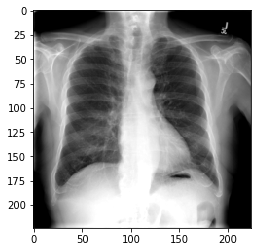

In [15]:
test = train_generator.next()
print(test[1][0])
plt.imshow(test[0][0]/255)

In [16]:
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
import keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

output = resnet.output
output = GlobalAveragePooling2D()(output)
resnet = Model(inputs=resnet.input, output=output)

for layer in resnet.layers:
    layer.trainable = False
    
# resnet.summary()
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

C:\Users\SeanK\Anaconda3\envs\py37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\SeanK\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
  # Remove the CWD from sys.path while we load stuff.


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001EF9B763898>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x000001EF9B76D630>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x000001EF9B76B668>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x000001EF9C0ACF28>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x000001EF9C0ACB00>,activation_1,False
...,...,...,...
171,<keras.layers.convolutional.Conv2D object at 0x000001EFCA103E80>,res5c_branch2c,False
172,<keras.layers.normalization.BatchNormalization object at 0x000001EFD350E400>,bn5c_branch2c,False
173,<keras.layers.merge.Add object at 0x000001EFD350ED68>,add_16,False
174,<keras.layers.core.Activation object at 0x000001EFD35210F0>,activation_49,False


In [18]:
# extracting features
for dataset, name in zip([train_generator, test_generator, val_generator], ['train', 'test', 'val']):
    features = np.zeros([dataset.n, 2048])
    class_vectors = np.zeros([dataset.n, 4])
    print(f'Starting {name} dataset')
    batch_idx = 0
    row_idx = 0
    for X, y in dataset:
        if row_idx+X.shape[0] > dataset.n:  
            over_by = (row_idx + X.shape[0]) - dataset.n
            print(f'Over by {over_by}')
            print(f'X: {X.shape[0]}')
            X = X[:(-1*over_by)]  # drops the images which are repeats
            y = y[:(-1*over_by)]
            print(f'New X: {X.shape[0]}')
        idxs = np.arange(row_idx, row_idx+X.shape[0])
        features[idxs] = resnet.predict(X)
        class_vectors[idxs] = y
        row_idx += X.shape[0]
        batch_idx += 1
        if batch_idx == len(dataset):
            break
    print(f'Finished {len(dataset.index_array)} images for {name} dataset')
    np.save(f'{name}-Xray-features.npy', features)
    np.save(f'{name}-Xray-truth.npy', class_vectors)

Starting train dataset
Finished 745 images for train dataset
Starting test dataset
Finished 208 images for test dataset
Starting val dataset
Finished 83 images for val dataset


In [19]:
Xtest = np.load('train-Xray-features.npy')
print(Xtest.shape)
print(Xtest[-1])
Ytest = np.load('train-Xray-truth.npy')
print(Ytest.shape)
print(Ytest[-1])

(745, 2048)
[1.55537915 1.88559639 0.12661202 ... 0.28172386 0.04091214 0.11010009]
(745, 4)
[0. 0. 0. 1.]
